In [ ]:
import numpy as np

In [ ]:
import tarfile
import os

# Define the path to the uploaded file and the extraction target directory
uploaded_file_path = 'SSH.tar.gz'
extraction_target_dir = 'SSH'

# Create the target directory if it doesn't already exist
if not os.path.exists(extraction_target_dir):
    os.makedirs(extraction_target_dir)

# Extract the .tar.gz file
with tarfile.open(uploaded_file_path, "r:gz") as tar:
    tar.extractall(path=extraction_target_dir)

# List the files in the extraction target directory
extracted_files = os.listdir(extraction_target_dir)
extracted_files


['SSH.log']

In [ ]:
# Define the path to the extracted log file
log_file_path = os.path.join(extraction_target_dir, 'SSH.log')

# Read and display the first few lines of the log file to understand its format
with open(log_file_path, 'r') as file:
    first_few_lines = [next(file) for _ in range(5)]

first_few_lines


['Dec 10 06:55:46 LabSZ sshd[24200]: reverse mapping checking getaddrinfo for ns.marryaldkfaczcz.com [173.234.31.186] failed - POSSIBLE BREAK-IN ATTEMPT!\n',
 'Dec 10 06:55:46 LabSZ sshd[24200]: Invalid user webmaster from 173.234.31.186\n',
 'Dec 10 06:55:46 LabSZ sshd[24200]: input_userauth_request: invalid user webmaster [preauth]\n',
 'Dec 10 06:55:46 LabSZ sshd[24200]: pam_unix(sshd:auth): check pass; user unknown\n',
 'Dec 10 06:55:46 LabSZ sshd[24200]: pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=173.234.31.186 \n']

In [ ]:
import pandas as pd
import re
from datetime import datetime


# Define a pattern to extract relevant parts of each log entry
log_pattern = re.compile(r'(?P<timestamp>\w+ \d+ \d+:\d+:\d+) (?P<host>\S+) sshd\[\d+\]: (?P<event>.*)')

# Initialize a list to hold parsed log data
parsed_logs = []

# Parse the log file
with open(log_file_path, 'r') as file:
    for line in file:
        match = log_pattern.match(line)
        if match:
            log_entry = match.groupdict()
            parsed_logs.append(log_entry)

# Convert the parsed log data into a DataFrame
df_logs = pd.DataFrame(parsed_logs)

df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'], format='%b %d %H:%M:%S', errors='coerce')
current_year = datetime.now().year
df_logs['timestamp'] = df_logs['timestamp'].apply(lambda x: x.replace(year=current_year))

df_logs['date'] = df_logs['timestamp'].dt.date

# Display the first few rows of the DataFrame to verify parsing
df_logs.head()

,timestamp,host,event,date
0,2024-12-10 06:55:46,LabSZ,reverse mapping checking getaddrinfo for ns.ma...,2024-12-10
1,2024-12-10 06:55:46,LabSZ,Invalid user webmaster from 173.234.31.186,2024-12-10
2,2024-12-10 06:55:46,LabSZ,input_userauth_request: invalid user webmaster...,2024-12-10
3,2024-12-10 06:55:46,LabSZ,pam_unix(sshd:auth): check pass; user unknown,2024-12-10
4,2024-12-10 06:55:46,LabSZ,pam_unix(sshd:auth): authentication failure; l...,2024-12-10


In [ ]:
# Define categories for different types of events based on keywords in the 'event' column
event_categories = {
    'invalid_user': 'Invalid user',
    'auth_failure': 'authentication failure',
    'reverse_mapping': 'reverse mapping checking',
    'userauth_request': 'input_userauth_request'
}

# Create a new column for event category
df_logs['event_category'] = 'other'  # Default category

# Assign categories based on the presence of keywords in the 'event' column
for category, keyword in event_categories.items():
    df_logs.loc[df_logs['event'].str.contains(keyword, case=False, na=False), 'event_category'] = category

# Count the occurrences of each category
event_category_counts = df_logs['event_category'].value_counts()

print(event_category_counts)

other               175416
auth_failure         88322
invalid_user         24250
userauth_request     10251
reverse_mapping       4038
Name: event_category, dtype: int64


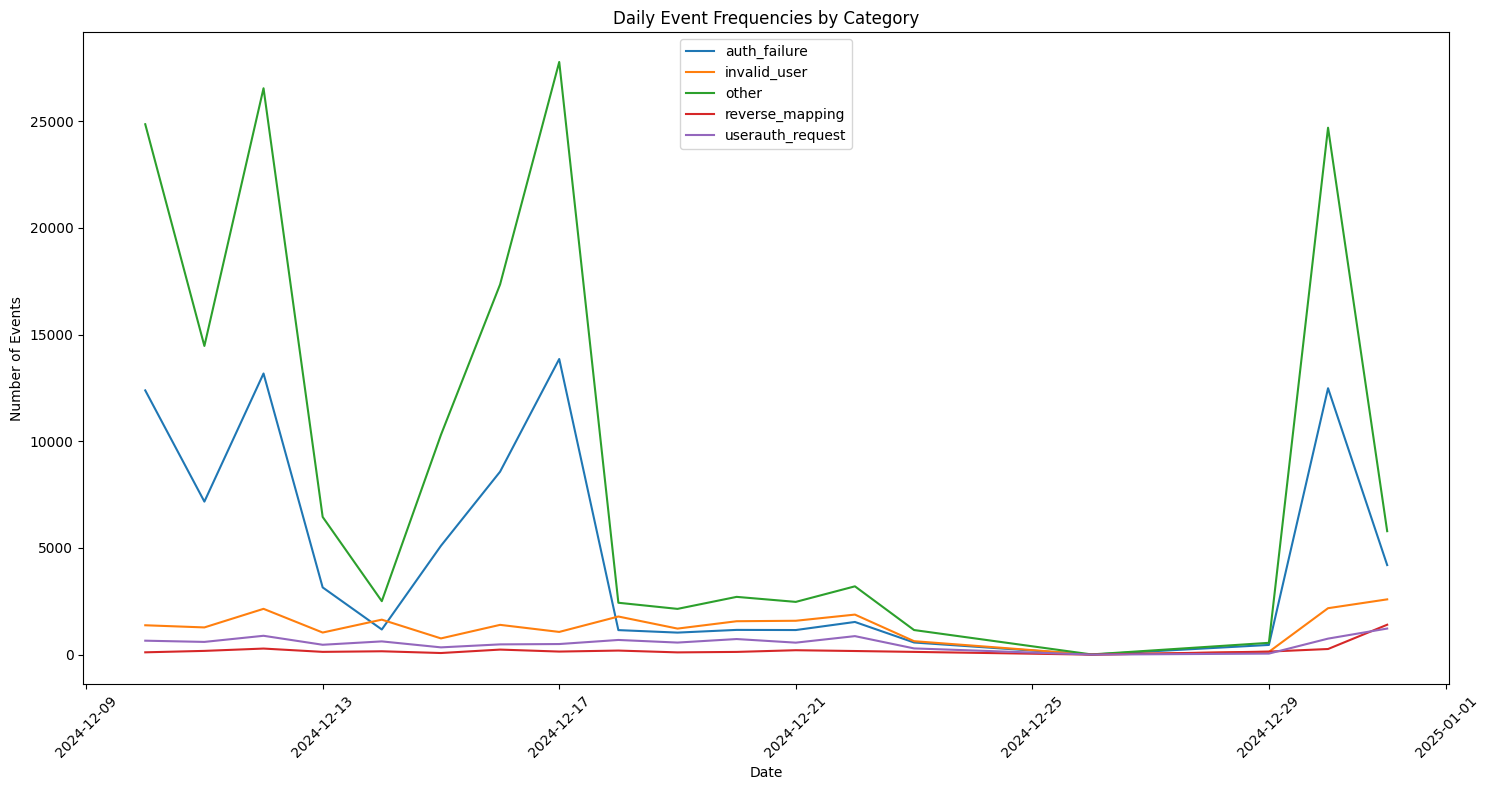

In [ ]:
import matplotlib.pyplot as plt

# Aggregate counts by date and event category
daily_event_counts = df_logs.groupby(['date', 'event_category']).size().unstack(fill_value=0)

# Plotting the corrected data
plt.figure(figsize=(15, 8))
for category in daily_event_counts.columns:
    plt.plot(daily_event_counts.index, daily_event_counts[category], label=category)

plt.title('Daily Event Frequencies by Category')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [ ]:
df_logs['event'].head()

0    reverse mapping checking getaddrinfo for ns.ma...
1           Invalid user webmaster from 173.234.31.186
2    input_userauth_request: invalid user webmaster...
3        pam_unix(sshd:auth): check pass; user unknown
4    pam_unix(sshd:auth): authentication failure; l...
Name: event, dtype: object

In [ ]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199772 sha256=a454d0e58846ae579ee2f4e5d34402104df009deedc36290020cc10aa5490e7a
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import numpy as np
import pandas as pd
import fasttext
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist

class OutlierDetectorWrapper:
    def __init__(self, text_column = 'event', n_clusters=4, n_components=5, random_state=42, batch_size=1000):
        self.data = pd.DataFrame()

        self.n_clusters = n_clusters
        self.n_components = n_components
        self.random_state = random_state
        self.text_column = text_column
        self.batch_size = batch_size


        self.unfitted_data = 0

    def append(self, new_data):
        self.data = pd.concat([self.data, new_data], ignore_index=True)
        self.unfitted_data += len(new_data)

    #fits/refits clusters & vectorizer
    def fit(self):
        self.unfitted_data = 0

        self.data[self.text_column].to_csv('events.txt', index=False)
        self.model = fasttext.train_unsupervised('events.txt', model='skipgram')

        self.detector = OutlierDetector(
            n_clusters=self.n_clusters, n_components=self.n_components,
            random_state=self.random_state, fasttext_model=self.model
        )
        self.detector.fit(self.data[self.text_column])

    #appends data and refits kmeans without refitting vectorizer
    def append_and_partial_refit(self, new_data):
      self.data = pd.concat([self.data, new_data], ignore_index=True)
      self.unfitted_data += new_data.shape[0]
      self.detector.fit_new_data(new_data[self.text_column])

    def detect_outliers(self):
        # Use the detector to find outliers in the current dataset
        return self.detector.detect_outliers()

    def predict_outliers(self, new_data):
        # Use the detector to predict outliers in new data (not appended)
        return self.detector.predict_outliers(new_data[self.text_column])

    def get_unfitted_data_size(self):
      #gets amount of data that's currently not fitted
      return self.unfitted_data

    def get_data_size(self):
      #gets all data size, including unfitted
      return self.data.shape[0]

class OutlierDetector:
    def __init__(self, n_clusters=4, n_components=5, random_state=42, fasttext_model=None, batch_size=1000):
        # Initialize FastText model
        if fasttext_model is None:
            # Load a pre-trained model or train here
            self.model = fasttext.load_model('cc.en.300.bin')  # Example: using a pre-trained model
        else:
            self.model = fasttext_model

        self.svd = TruncatedSVD(n_components=n_components, random_state=random_state)
        self.kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state, batch_size=batch_size)
        self.random_state = random_state

    def vectorize(self, data):
        # Vectorize data using FastText
        vectors = np.array([self.model.get_sentence_vector(text) for text in data])
        return vectors

    def fit(self, data):
        # Vectorize the text data
        X = self.vectorize(data)
        X_normalized = normalize(X, norm='l2', axis=1)

        # Dimensionality reduction
        X_svd_normalized = self.svd.fit_transform(X_normalized)

        # Clustering
        self.kmeans.fit(X_svd_normalized)

        # Calculate distance to centroids
        centroids = self.kmeans.cluster_centers_
        distances = cdist(X_svd_normalized, centroids, 'euclidean')
        self.min_distances = distances.min(axis=1)

        # Calculate threshold for outliers
        q1 = np.percentile(self.min_distances, 25)
        q3 = np.percentile(self.min_distances, 75)
        iqr = q3 - q1
        self.threshold = q3 + (1.5 * iqr)

    def detect_outliers(self):
        outliers = np.where(self.min_distances > self.threshold)[0]
        return outliers

    def predict_outliers(self, new_data):
        # Apply the same transformations to the new data
        X_new = self.vectorize(new_data)
        X_new_normalized = normalize(X_new, norm='l2', axis=1)
        X_new_svd_normalized = self.svd.transform(X_new_normalized)

        # Calculate distance to centroids
        centroids = self.kmeans.cluster_centers_
        distances_new = cdist(X_new_svd_normalized, centroids, 'euclidean')
        min_distances_new = distances_new.min(axis=1)

        # Determine if they are outliers based on the threshold
        is_outlier = min_distances_new > self.threshold
        return is_outlier

    def fit_new_data(self, new_data):
        # Vectorize and normalize the new data
        X_new = self.vectorize(new_data)
        X_new_normalized = normalize(X_new, norm='l2', axis=1)

        # Dimensionality reduction on the new data
        X_new_svd_normalized = self.svd.transform(X_new_normalized)

        self.kmeans.partial_fit(X_new_svd_normalized)

# Example usage:
# detector = OutlierDetectorWrapper()
# detector.append(df_logs[:-10])
# detector.fit()
# outliers = detector.detect_outliers()
# detector.predict_outliers(df_logs[-10:])
# detector.partial_refit(df_logs[-10:])

In [ ]:
#all your data at once
detector = OutlierDetectorWrapper()
detector.append(df_logs[:-10])
detector.fit()
outliers = detector.detect_outliers()
detector.predict_outliers(df_logs[-10:])
detector.append_and_partial_refit(df_logs[-10:])



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'OutlierDetectorWrapper' object has no attribute 'partial_refit'

In [ ]:
outlier_rows = df_logs.iloc[outliers]
outlier_rows[:20]

,timestamp,host,event,date,event_category
21,2024-12-10 07:11:42,LabSZ,Invalid user chen from 202.100.179.208,2024-12-10,invalid_user
22,2024-12-10 07:11:42,LabSZ,input_userauth_request: invalid user chen [pre...,2024-12-10,userauth_request
152,2024-12-10 07:51:12,LabSZ,Invalid user support from 195.154.37.122,2024-12-10,invalid_user
153,2024-12-10 07:51:12,LabSZ,input_userauth_request: invalid user support [...,2024-12-10,userauth_request
170,2024-12-10 07:56:14,LabSZ,Invalid user support from 103.207.39.165,2024-12-10,invalid_user
171,2024-12-10 07:56:14,LabSZ,input_userauth_request: invalid user support [...,2024-12-10,userauth_request
204,2024-12-10 08:24:58,LabSZ,input_userauth_request: invalid user admin [pr...,2024-12-10,userauth_request
208,2024-12-10 08:25:06,LabSZ,input_userauth_request: invalid user admin [pr...,2024-12-10,userauth_request
224,2024-12-10 08:25:27,LabSZ,input_userauth_request: invalid user admin [pr...,2024-12-10,userauth_request
240,2024-12-10 08:25:48,LabSZ,input_userauth_request: invalid user admin [pr...,2024-12-10,userauth_request


In [ ]:
#feed data in 1000 lines at a time
incremental_detector = OutlierDetectorWrapper()
i = 1000
n = df_logs.shape[0]
incremental_detector.append(df_logs[0: 1000])
incremental_detector.fit()
outliers = incremental_detector.detect_outliers()

is_outlier = []
while (i < n):

  if (incremental_detector.get_unfitted_data_size() >= incremental_detector.get_data_size()/2):
    incremental_detector.fit()

  prediction_is_outlier = incremental_detector.predict_outliers(df_logs[i: i + 1000])
  is_outlier.append(prediction_is_outlier)
  incremental_detector.append_and_partial_refit(df_logs[i: i + 1000])
  i += 1000



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

In [ ]:
print(is_outlier[0:10])

[array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False

In [ ]:
# import fasttext

# df_logs['event'].to_csv('events.txt', index=False)
# model = fasttext.train_unsupervised('events.txt', model='skipgram')

# detector = DataClusterOutlierDetector(fasttext_model=model)
# detector.fit(df_logs['event'])
# outliers = detector.detect_outliers()
# print("Outlier indices:", outliers)
# outlier_rows = df_logs.iloc[outliers]
# print(outlier_rows.head())
# print(detector.predict_outliers(["Invalid user support", "Valid user, login succesful"]))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Outlier indices: [     8     21    140 ... 302160 302176 302182]
              timestamp   host  \
8   2024-12-10 07:07:38  LabSZ   
21  2024-12-10 07:11:42  LabSZ   
140 2024-12-10 07:42:49  LabSZ   
141 2024-12-10 07:42:49  LabSZ   
152 2024-12-10 07:51:12  LabSZ   

                                                 event        date  \
8                 Invalid user test9 from 52.80.34.196  2024-12-10   
21              Invalid user chen from 202.100.179.208  2024-12-10   
140            Invalid user inspur from 183.136.162.51  2024-12-10   
141  input_userauth_request: invalid user inspur [p...  2024-12-10   
152           Invalid user support from 195.154.37.122  2024-12-10   

       event_category  
8        invalid_user  
21       invalid_user  
140      invalid_user  
141  userauth_request  
152      invalid_user  


In [ ]:
# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import normalize
# from sklearn.decomposition import TruncatedSVD
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# class DataClusterOutlierDetector:
#     def __init__(self, n_clusters=4, n_components=5, random_state=42, min_data_size=1000, min_to_refit = 500):
#         self.vectorizer = TfidfVectorizer()
#         self.svd = TruncatedSVD(n_components=n_components, random_state=random_state)
#         self.kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
#         self.random_state = random_state
#         self.data = []
#         self.min_data_size = min_data_size
#         self.min_to_refit = min_to_refit
#         self.is_model_trained = False

#     def fit(self):
#         X = self.vectorizer.fit_transform(self.data)
#         X_normalized = normalize(X, norm='l2', axis=1)
#         X_svd_normalized =self.svd.fit_transform(X_normalized)
#         self.kmeans.fit(X_svd_normalized)
#         self.calculate_threshold(X_svd_normalized)
#         self.is_model_trained = True

#     def calculate_threshold(self, X):
#         centroids = self.kmeans.cluster_centers_
#         distances = cdist(X, centroids, 'euclidean')
#         self.min_distances = distances.min(axis=1)
#         q1 = np.percentile(self.min_distances, 25)
#         q3 = np.percentile(self.min_distances, 75)
#         iqr = q3 - q1
#         self.threshold = q3 + (1.5 * iqr)

#     def predict_outliers(self, new_data):

#         X_1 = self.vectorizer.transform(new_data)
#         X_2 = normalize(X_1, norm='l2', axis=1)
#         X_new =self.svd.transform(X_2)

#         distances = cdist(X_new, self.kmeans.cluster_centers_, 'euclidean')
#         min_distances_new = distances.min(axis=1)
#         outliers_new = np.where(min_distances_new > self.threshold)[0]
#         return outliers_new

#     def process_input(self, input_data):
#         # Accumulate data
#         self.data.extend(input_data)

#         # If enough data and model not trained, fit the model
#         if len(self.data) >= self.min_data_size and not self.is_model_trained:
#             print("performing initial model training")
#             self.fit(self.data)

#         # If model is trained, predict outliers in the new input
#         if self.is_model_trained:
#             return input_data.iloc[self.predict_outliers(input_data)]
#         else:
#             return []

# # Example usage:
# # detector = DataClusterOutlierDetector(min_data_size=100)
# # For new inputs:
# # predictions = detector.process_input(new_data)
# # If predictions is not empty, it contains the indices of outliers in `new_data`.


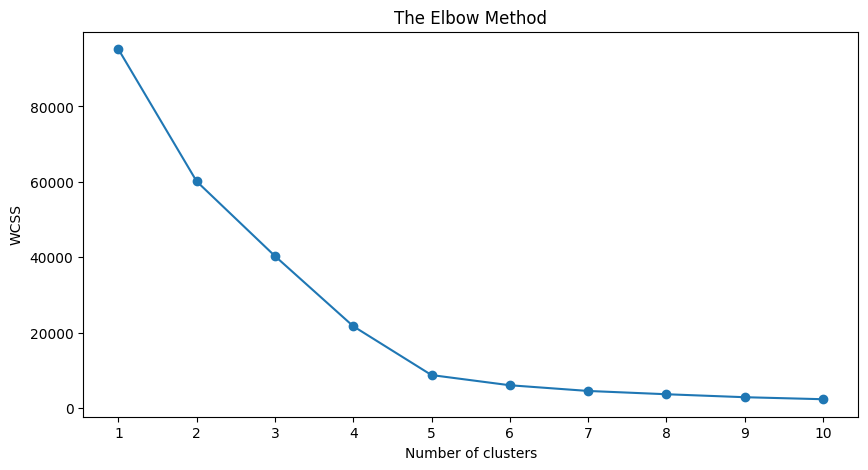

In [ ]:
# #elbow method, just to figure out how many k clusters to use
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# # Assuming X_svd_normalized is your dataset after preprocessing
# wcss = []
# for i in range(1, 11):  # Example range for K
#     kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans.fit(X_svd_normalized)
#     wcss.append(kmeans.inertia_)

# # Plotting the results onto a line graph
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, 11), wcss, marker='o')
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')  # Within-cluster sum of squares
# plt.xticks(range(1, 11))
# plt.show()
